In [2]:
import pandas as pd
from plotnine import *
from geopandas import GeoDataFrame
import folium
import shapely.affinity
from shapely.geometry import Point, LineString
import geopy
import geopy.distance
import random
import geopandas as gpd

import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
%matplotlib inline

In [212]:
shp_path ='/Users/theresejoseph/Documents/Neural_Network_Playground/data/Geospatial/Brisbane/gis_osm_roads_free_1.shp' 
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,1881386,5122,residential,Anglo Road,None,F,50,0,F,F,"LINESTRING (151.09789 -33.91319, 151.09910 -33..."
1,1881388,5122,residential,Loch Street,None,B,50,0,F,F,"LINESTRING (151.09770 -33.91285, 151.09775 -33..."
2,1881389,5115,tertiary,Evaline Street,None,B,50,0,F,F,"LINESTRING (151.09782 -33.91558, 151.09783 -33..."
3,1881520,5115,tertiary,Clements Parade,None,B,0,0,F,F,"LINESTRING (151.08040 -34.03458, 151.08030 -34..."
4,1881523,5115,tertiary,Hotham Road,None,B,0,0,F,F,"LINESTRING (151.08040 -34.03458, 151.08043 -34..."


In [248]:
center = [-27.470125, 153.021072]

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

# roads data
brisbane = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()

# brisbane=brisbane[brisbane['name'].notnull()]
brisbane=brisbane[brisbane['maxspeed']>0]
# brisbane['name'] = brisbane['name'].fillna(value='')
print(brisbane.shape)
# print(brisbane.maxspeed)

# brisbane = brisbane[brisbane.fclass.isin(['trunk', 'primary']) | brisbane['name'].notnull()]
# brisbane['postfix'] = brisbane['name'].apply(lambda name: name.split(' ')[-1] if name is not None else None)
# brisbane.maxspeed.value_counts()

(8509, 11)


In [222]:
# def get_designation(fclass):
#     fclass = fclass.lower()
#     if 'residential' in fclass: return 'residential'
#     elif ' tertiary' in fclass: return 'tertiary'
#     elif 'secondary' in fclass: return 'secondary'
#     elif 'primary' in fclass: return 'primary'
#     elif 'trunk' in fclass: return 'trunk'
#     elif 'service' in fclass: return 'service'
#     elif 'motorway' in fclass: return 'motorway'
#     elif 'unclassified' in fclass: return 'unclassified'
#     elif 'cycleway' in fclass: return 'cycleway'
#     elif 'track' in fclass: return 'track'
#     elif any(ext in fclass for ext in ['primary_link', 'motorway_link', 'tertiary_link', 'secondary_link', 'trunk_link']):
#         return 'links'
#     elif any(ext in fclass for ext in ['footway', 'pedestrian', 'path']):
#         return 'walkway'
#     else: return 'others'

# brisbane['designation'] = [get_designation(fclass) for fclass in brisbane['fclass']]
# print(brisbane.designation.value_counts())


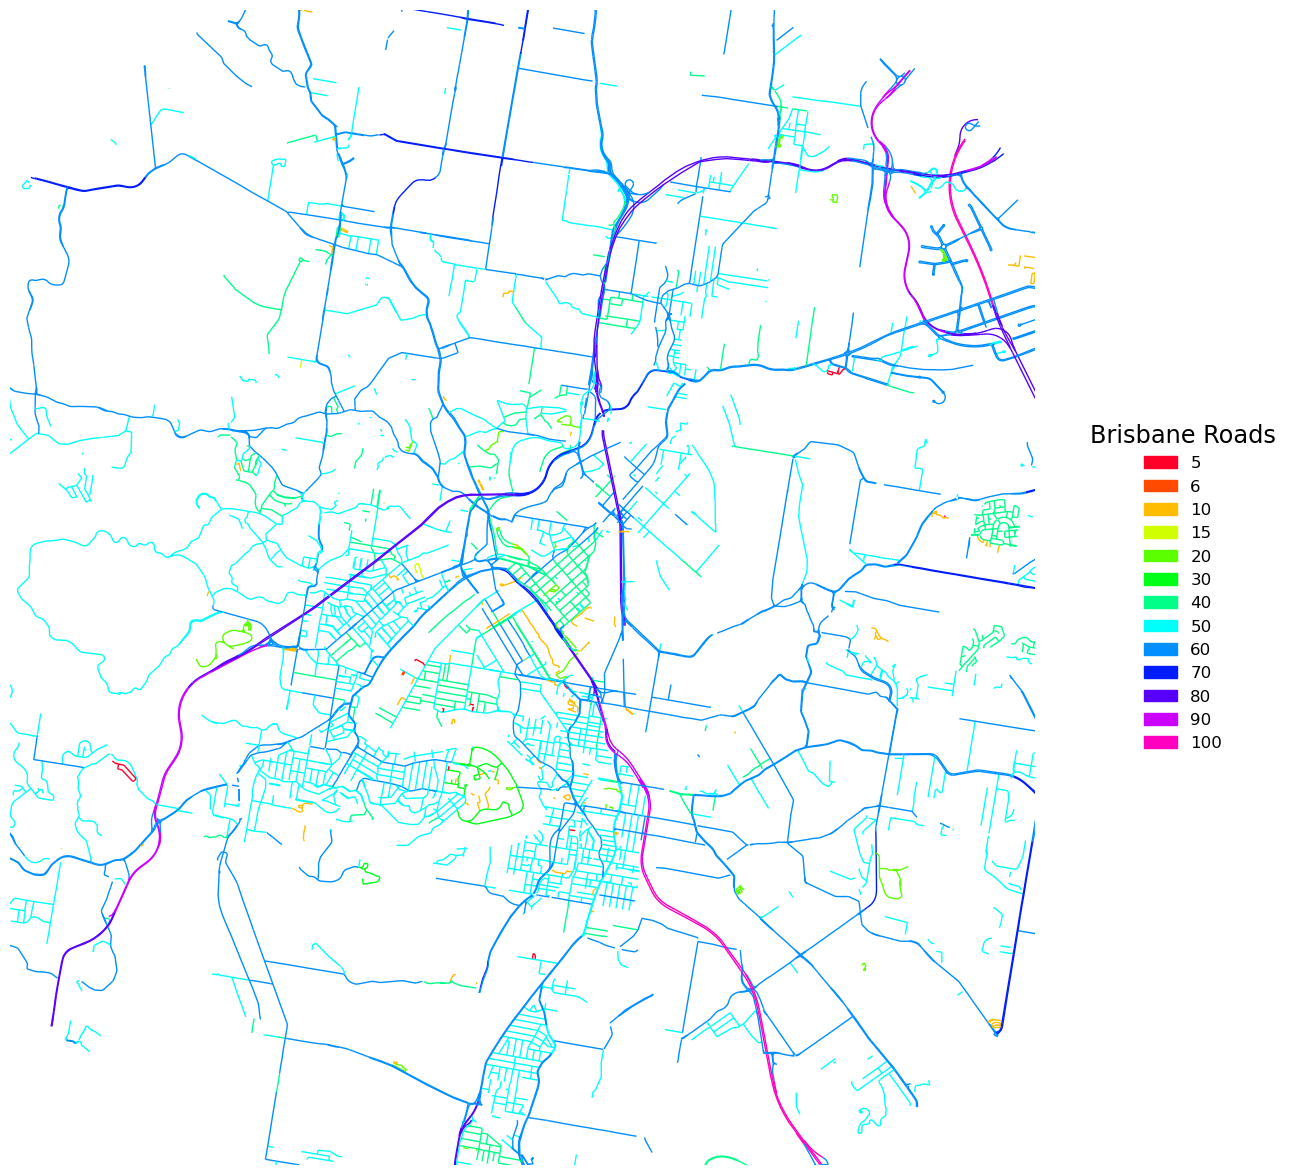

In [249]:
top = -27.39
bottom = -27.55
left = 152.94
right = 153.10

unqiue_speeds=np.sort(brisbane.maxspeed.unique())

cmap = plt.get_cmap('gist_rainbow', len(unqiue_speeds) )
colorMap=[cmap(i) for i in range(len(unqiue_speeds))]

colors = dict(zip(unqiue_speeds, colorMap))

# colors = {
#     'residential': '#59c8e5',
#     'links': '#0000FF',
#     'secondary': '#fed032',
#     'primary': '#9A7D0A',
#     'trunk': '#fe4d64',
#     'service': '#ffb366',
#     'unclassified': '#764cbd',
#     'motorway': '#E74C3C',
#     'cycleway': '#0a7abf',
#     'walkway': '#4cb580',
#     'track': '#2e968c',
#     'others': '#cccccc'
# }

def plot_and_save(
    top,
    bottom,
    left,
    right,
    linewidth,
    linewidth_lane,
    legend_title,
    legend_bbox,
    path,
    english=False,
    dpi=300
    ):
    
    f, ax = plt.subplots(1, figsize=(15, 15))

    brisbane.plot(ax=ax,
                color=[colors[d] for d in brisbane.maxspeed],
                linewidth=[linewidth if d != 'переулок' else linewidth_lane for d in brisbane.maxspeed])
    ax.set_aspect(1/math.cos(math.pi/180*center[0]))
    ax.set_ylim((bottom, top))
    ax.set_xlim((left, right))

    plt.axis('off')
    
    plt.legend(handles=[mpatches.Patch(color=colors[k], 
                                       label= k) for k in colors],
               loc='center right',
               fontsize='large',
               edgecolor='none',
               title=legend_title,
               title_fontsize='xx-large',
               bbox_to_anchor=legend_bbox)

    plt.savefig(path, bbox_inches='tight', dpi=dpi)

savePath='/Users/theresejoseph/Documents/Neural_Network_Playground/results/brisbane.png'
plot_and_save(top, bottom,left,right,1,0.7,'Brisbane Roads',(1.25,0.5),savePath)


In [3]:
#load shape file 
shp_path ='/Users/theresejoseph/Documents/Neural_Network_Playground/data/Geospatial/Berlin/gis_osm_roads_free_1.shp' 
roads_berlin = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads_berlin.head()


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4045150,5122,residential,Waldstraße,None,B,50,0,F,F,"LINESTRING (13.60524 52.37344, 13.60528 52.373..."
1,4045194,5122,residential,Ursula-Goetze-Straße,None,B,30,0,F,F,"LINESTRING (13.53136 52.49263, 13.53136 52.492..."
2,4045220,5122,residential,Hönower Straße,None,F,30,0,F,F,"LINESTRING (13.52694 52.48969, 13.52639 52.489..."
3,4045223,5122,residential,Gundelfinger Straße,None,F,30,0,F,F,"LINESTRING (13.52477 52.48558, 13.52484 52.485..."
4,4045243,5113,primary,Frankfurter Allee,B 1;B 5,F,50,0,F,F,"LINESTRING (13.45420 52.51571, 13.45440 52.515..."


In [4]:
center = [52.520008,13.404954]
# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 10).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

# roads data
berlin = roads_berlin.loc[roads_berlin['geometry'].apply(lambda g: ellipse.contains(g))].copy()

berlin=berlin[berlin['maxspeed']>0]
# berlin['name'] = berlin['name'].fillna(value='')

berlin.shape



(28229, 11)

In [5]:
unqiue_speeds=np.sort(berlin.maxspeed.unique())

print(unqiue_speeds)
cmap = plt.get_cmap('gist_rainbow', len(unqiue_speeds) )
colorMap=[cmap(i) for i in range(len(unqiue_speeds))]

colors = dict(zip(unqiue_speeds, colorMap))

# colors = {
#     0: '#59c8e5',
#     5: '#0000FF',
#     7: '#fed032',
#     10: '#9A7D0A',
#     15: '#fe4d64',
#     20: '#ffb366',
#     30: '#764cbd',
#     40: '#E74C3C',
#     50: '#0a7abf',
#     60: '#4cb580',
#     70: '#2e968c',
#     80: '#cccccc'
# }

# def convert2km(x):
#     middle=[13.404954,52.520008]
#     coords = (np.array(x.coords) - middle)*111.139
#     return LineString(coords)

# print(berlin.geometry.map(convert2km)[7])

# print(berlin.geometry[7])


[  5   6   7  10  15  17  20  30  40  50  60  70  80 100]


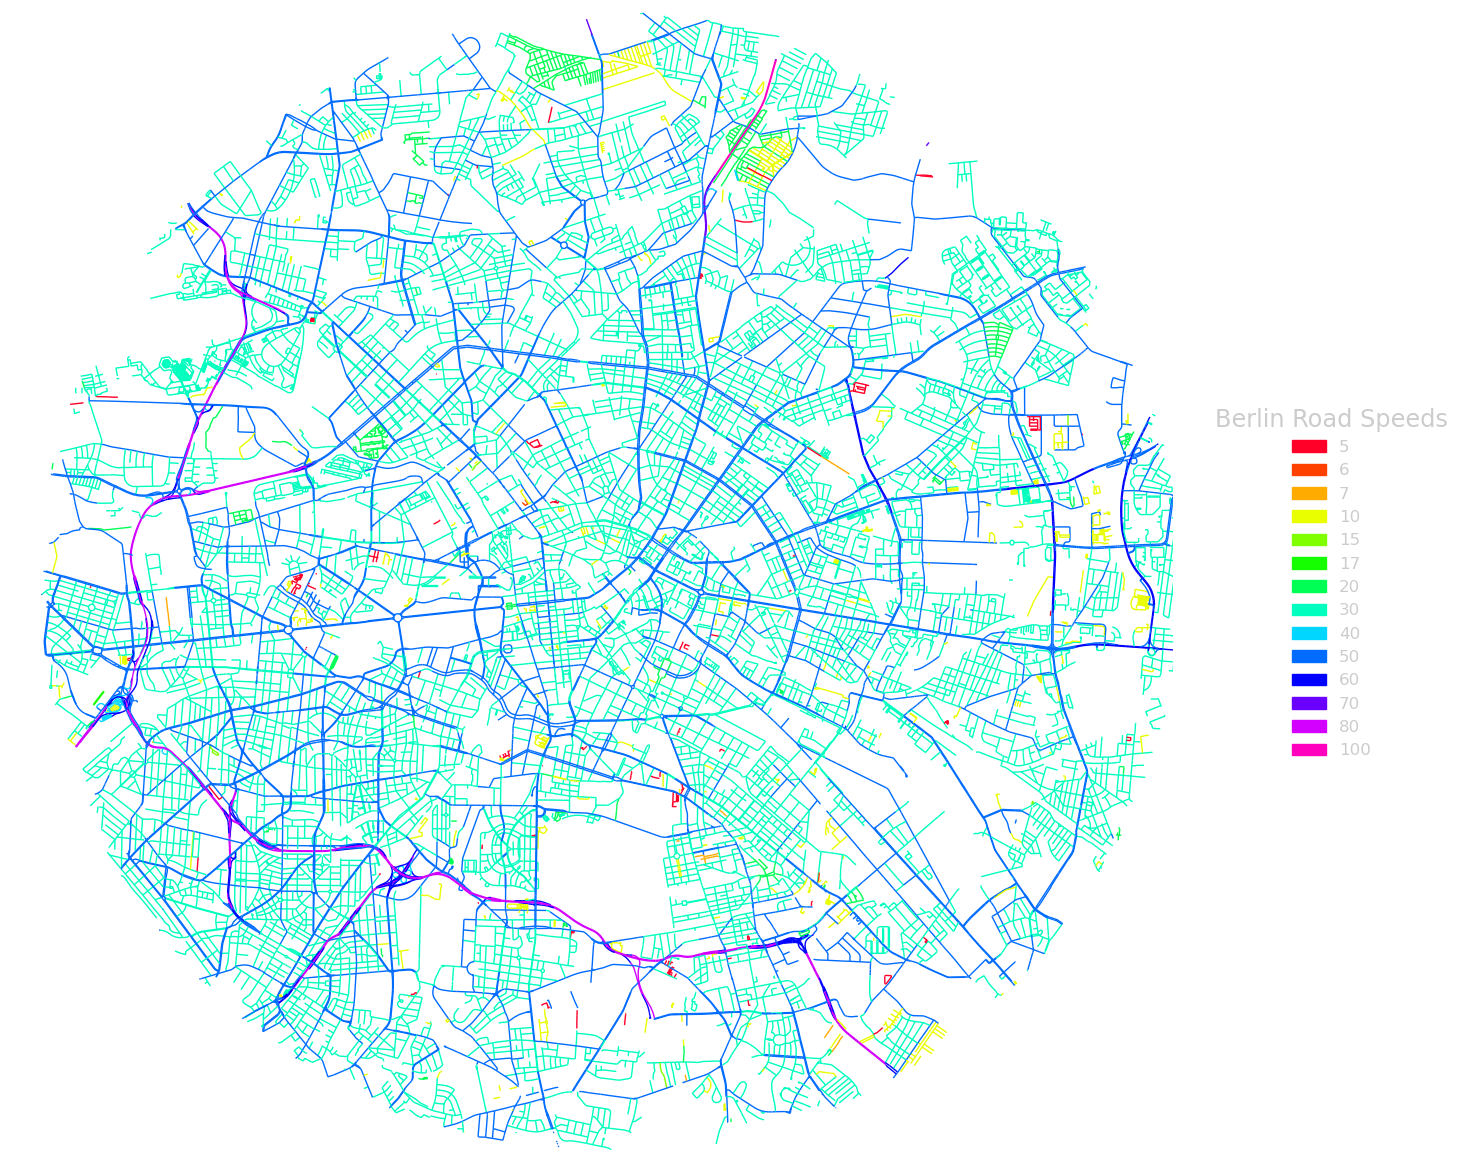

In [14]:
points = gpd.GeoSeries([Point(13.2,52.62), Point(13.4, 52.62)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)
distance_meters = points[0].distance(points[1])

top = 52.61
bottom = 52.43
left = 13.25
right = 13.55
linewidth_lane=0.05
legend_title= 'Berlin Road Speeds'
legend_bbox=(1.25,0.5)

f, ax = plt.subplots(1, figsize=(15, 15))

a=berlin.plot(ax=ax, linewidth=1,
            color=[colors[d] for d in berlin.maxspeed])
ax.set_aspect(1/math.cos(math.pi/180*center[0]))
ax.set_ylim((bottom, top))
ax.set_xlim((left, right))
# a.set_linewidth(1)
# a.add_artist(ScaleBar(distance_meters))

plt.axis('off')

legend=plt.legend(handles=[mpatches.Patch(color=colors[k], 
                                    label= k) for k in colors],
            labelcolor='0.8',
            loc='center right',
            fontsize='large',
            edgecolor='none',
            title=legend_title,
            title_fontsize='xx-large',
            bbox_to_anchor=legend_bbox)
plt.setp(legend.get_title(), color='0.8')
dpi=500
savePath2='/Users/theresejoseph/Documents/Neural_Network_Playground/results/berlin.png'
plt.savefig(savePath2, bbox_inches='tight', dpi=dpi)


In [15]:
from PIL import Image
def convertImage():
    img = Image.open(savePath2)
    img = img.convert("RGBA")
 
    datas = img.getdata()
 
    newData = []
 
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
 
    img.putdata(newData)
    img.save(savePath2, "PNG")
    print("Successful")
convertImage()

Successful
